In [398]:
import os 
import dill
from typing import Any
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import jax
import jax.numpy as jnp
from getdist import plots, MCSamples
import getdist
import glob
from astropy.io import fits
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median
import scipy.stats as ss 
from scipy.special import logsumexp, softmax
import tqdm
import torch 
import random
import torch.nn as nn
import flowtorch.bijectors as bij
import flowtorch.distributions as tdist
import flowtorch.parameters as params
import harmonic as hm
import warnings
warnings.filterwarnings("ignore")

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [576]:
def get_paramnames(main):
    """
    Retrieve parameter names from subdirectories within a specified main directory.

    This function scans through each subdirectory in the given main directory,
    looking for files with the '.paramnames' suffix. It collects the base names
    (without the suffix) and constructs full paths to these parameter names.

    Args:
        main (str): The path to the main directory containing subdirectories.

    Returns:
        list: A list of full paths for each parameter name found.
    """
    # Initialize a dictionary to store parameter names by subdirectory
    paramnames_dict = {}

    # List all folders in the main directory
    for expdetail in os.listdir(main):
        folder_path = os.path.join(main, expdetail)  # Create full folder path
        
        if os.path.isdir(folder_path):  # Ensure it's a directory
            # Initialize a list to collect parameter names
            paramnames = [
                f.split('.')[0] for f in os.listdir(folder_path) if 'paramnames' in f
            ]
            paramnames_dict[expdetail] = paramnames

    # Construct full paths for the collected parameter names
    full_paths = [
        f"{main}/{expdetail}/{paramname}" 
        for expdetail, paramnames in paramnames_dict.items() 
        for paramname in paramnames
    ]

    return full_paths

def get_columns_latex(fpath):
    """
    Extract column names and LaTeX representations from a parameter names file.

    This function reads a parameter names file corresponding to the specified 
    file path, extracts variable names and their LaTeX representations, and 
    constructs a structured dictionary containing these details along with 
    generated chain names.

    Args:
        fpath (str): The file path without the extension of the parameter names file.

    Returns:
        dict: A dictionary containing columns and LaTeX representations.
    """
    # Get the MCMC name from the file path
    mcmc_name = os.path.basename(fpath)

    # Read the parameter names from the file
    with open(f'{fpath}.paramnames', 'r') as file:
        data_list = file.read().strip().splitlines()

    # Initialize the result dictionary structure
    result_dict = {
            'columns': [],
            'latex': [],
        }

    # Extract names and LaTeX representations
    for item in data_list:
        name, latex_name = item.split('\t')  # Split at the tab character
        result_dict['columns'].append(name)
        result_dict['latex'].append(f'${latex_name}$')  # Format LaTeX names

    return result_dict

def get_latex_labels(info: dict) -> list:
    """
    Extract LaTeX labels from the provided dictionary while ignoring 
    labels associated with columns that contain an asterisk (*).

    Parameters:
    info (dict): A dictionary containing two keys:
        - 'columns': A list of column names.
        - 'latex': A list of LaTeX labels corresponding to the columns.

    Returns:
    list: A list of LaTeX labels for columns that do not contain an asterisk.
    """
    
    column_names = info['columns']
    latex_labels = info['latex']
    filtered_labels = []

    for column, label in zip(column_names, latex_labels):
        if "*" not in column:
            filtered_labels.append(label)

    return filtered_labels

def get_mcmc_samples(fpath):
    """
    Load MCMC samples from text files and create a DataFrame with specified columns.

    This function retrieves MCMC samples from text files corresponding to the 
    provided file path, processes the samples to create a structured DataFrame,
    and returns the experiment name along with the DataFrame and parameter 
    information.

    Args:
        fpath (str): The base file path for the MCMC samples (without extension).

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: A DataFrame containing MCMC samples with relevant columns.
            - dict: Information about parameter names and their LaTeX representations.
    """
    # Retrieve parameter names and LaTeX information
    info = get_columns_latex(fpath)
    info['path'] = fpath
    
    # Extract the experiment name from the file path
    info['experiment'] = fpath.split('/')[-1]
    
    # Construct the DataFrame columns
    columns = ['counts', 'logp'] + info['columns']
    
    # Load MCMC samples from text files
    samples_list = [np.loadtxt(f'{fpath}_{i + 1}.txt') for i in range(4)]
    combined_samples = np.concatenate(samples_list)
    
    # Adjust the log likelihood values
    combined_samples[:, 1] *= -1

    # Create a DataFrame with the samples
    samples_df = pd.DataFrame(combined_samples, columns=columns)

    # Filter out columns with '*' in their names, excluding the first column
    filtered_columns = [col for col in columns if '*' not in col][1:]
    filtered_derived = [s for s in columns if "*" in s and "chi2" not in s]
    
    return samples_df[filtered_columns], samples_df[filtered_derived], info

In [116]:
index = 10
base_index = 18
experiments = os.listdir('./')
base_experiments = [word for word in experiments if word.startswith('base')]
nexperiments = [len(get_paramnames(base)) for base in base_experiments]
allpaths = get_paramnames(base_experiments[base_index])
df, info = get_mcmc_samples(allpaths[index])

In [63]:
print(f'Total number of base experiments : {len(base_experiments)}')
print(f'Total number of experiments      : {sum(nexperiments)}')
print(f'Looking at experiment : {base_experiments[base_index]}')
print(f'Looking at the folder : {allpaths[index]}')
print(f'Total number of experiments is : {len(allpaths)}')
print(f'Total number of samples is     : {df.shape[0]}')
print(f'Total number of parameters is  : {df.shape[1]-1}')

Total number of base experiments : 19
Total number of experiments      : 1297
Looking at experiment : base_w
Looking at the folder : base_w/CamSpecHM_TTTEEE_lowl_lowE/base_w_CamSpecHM_TTTEEE_lowl_lowE_post_lensing_zre6p5
Total number of experiments is : 75
Total number of samples is     : 4637
Total number of parameters is  : 25


In [64]:
df.head()

,logp,omegabh2,omegach2,theta,tau,w,logA,ns,calPlanck,aps100,...,xi,aksz,dust100,dust143,dust217,dust143x217,cal0,cal2,calTE,calEE
0,-5980.440,0.022540,0.119348,1.040617,0.052347,-1.689071,3.025051,0.961269,0.993552,227.0245,...,0.195831,4.957600,1.187610,0.881888,0.743071,0.724486,0.996604,1.003315,0.997964,0.992522
1,-5978.445,0.022590,0.119714,1.041027,0.048339,-1.525562,3.019825,0.961997,0.994856,232.8012,...,0.523501,7.026108,1.177625,1.158623,0.815641,0.676565,0.995987,1.002144,0.996308,0.987131
2,-5975.674,0.022444,0.120063,1.041046,0.057223,-1.465527,3.039265,0.960711,0.996496,224.6414,...,0.295919,5.691122,0.891657,0.870957,0.967720,1.033003,0.996336,1.001394,0.992446,0.976865
3,-5972.100,0.022400,0.119750,1.040514,0.054897,-1.933600,3.037843,0.965185,0.997987,263.4723,...,0.111544,8.207831,1.040822,0.638267,1.075017,1.170520,0.997621,1.003293,0.999172,0.994049
4,-5978.811,0.022450,0.119722,1.040811,0.060870,-1.819309,3.052605,0.967544,0.998193,297.9501,...,0.592792,9.549760,0.907212,0.998685,1.041962,1.245834,0.998588,1.000527,0.985506,0.984647


## Evidence Estimate

In [463]:
class ThetaTransform:
    """
    A class to perform a linear transformation on parameter samples using a Cholesky decomposition 
    of their covariance matrix. The transformation standardizes the parameters such that they are 
    transformed to a new space where their covariance is the identity matrix.

    Attributes:
    ----------
    ndim : int
        The number of dimensions of the parameter samples.
    pcov : ndarray
        Covariance matrix of the input samples.
    chol : ndarray
        Cholesky decomposition (lower triangular) of the covariance matrix.
    chol_inv : ndarray
        Inverse of the Cholesky decomposition.
    mean : ndarray
        Mean vector of the input samples.
    logdetchol : float
        Logarithm of the determinant of the Cholesky matrix.

    Methods:
    -------
    forward(parameter):
        Transforms the input parameters to the standardized space using the inverse Cholesky transform.
    
    inverse(parameterprime):
        Transforms parameters from the standardized space back to the original parameter space.
    """

    def __init__(self, samples):
        """
        Initializes the ThetaTransform object with parameter samples.
        
        Parameters:
        ----------
        samples : ndarray
            A 2D array of shape (N, D) where N is the number of samples and D is the dimensionality of the parameters.
        """
        self.ndim = samples.shape[1]
        self.pcov = np.cov(samples.T)
        self.chol = np.linalg.cholesky(self.pcov)
        self.chol_inv = np.linalg.inv(self.chol)
        self.mean = np.mean(samples, axis=0).reshape(-1, self.ndim)
        self.logdetchol = np.linalg.slogdet(self.chol)[1]

    def forward(self, parameter):
        """
        Transforms the input parameter(s) to the standardized space using the inverse Cholesky decomposition.
        
        Parameters:
        ----------
        parameter : ndarray
            A 1D or 2D array of shape (D,) or (N, D) where D is the dimensionality of the parameters and N is the number of parameter sets.
        
        Returns:
        -------
        parameterprime : ndarray
            The transformed parameter(s) in the standardized space, with the same shape as the input.
        """
        parameter = parameter.reshape(-1, self.ndim)
        parameterprime = self.chol_inv @ (parameter - self.mean).T
        return parameterprime.T

    def inverse(self, parameterprime):
        """
        Transforms the parameter(s) from the standardized space back to the original parameter space.
        
        Parameters:
        ----------
        parameterprime : ndarray
            A 1D or 2D array of shape (D,) or (N, D) where D is the dimensionality of the standardized parameters and N is the number of parameter sets.
        
        Returns:
        -------
        parameter : ndarray
            The parameter(s) transformed back to the original space, with the same shape as the input.
        """
        parameterprime = parameterprime.reshape(-1, self.ndim)
        parameter = self.chol @ parameterprime.T + self.mean.T
        return parameter.T
        
def logprior(theta):
    """
    Compute the log-prior probability density of the model parameters theta under a multivariate normal prior.

    Parameters:
    ----------
    theta : array-like
        A 1D or 2D array representing the model parameters. If a 1D array is passed, it will be converted to 
        a 2D array where each row is a set of parameters. The shape of `theta` is (n_samples, n_params), where
        n_samples is the number of parameter sets and n_params is the number of parameters in each set.

    Returns:
    -------
    float
        The log-prior value of the parameter set `theta`, assuming a multivariate normal prior distribution 
        with zero mean and identity covariance matrix.

    Notes:
    ------
    - This function assumes a standard multivariate normal prior with a mean of zero and an identity 
      covariance matrix, i.e., `N(0, I)`, where `I` is the identity matrix.
    - The log-prior is often used in Bayesian inference to quantify the prior belief about the model parameters 
      before observing any data. It reflects how likely certain parameter values are based on prior knowledge.

    Example:
    --------
    If you have a parameter vector `theta`, you can compute its log-prior as follows:
    
    >>> logprior(theta)
    
    This will return the log of the prior probability density of `theta` assuming a multivariate normal 
    prior with zero mean and identity covariance.

    """
    theta = np.atleast_2d(theta)
    nparams = theta.shape[1]
    mean = np.zeros(nparams)
    cov = np.eye(nparams)
    dist = ss.multivariate_normal(mean, cov)
    return dist.logpdf(theta)

def build_network(hidden=(32, 32, 32)):
    """Creates a function to do the mapping

    Args:
        hidden (tuple, optional): Number of hidden layers. Defaults to (32, 32, 32).

    Returns:
        flowtorch.lazy.lazy: a composition of bijectors
    """

    transforms = bij.Compose(
        bijectors=[
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
        ]
    )
    return transforms


class NormFlow:
    def __init__(self, samples):

        ndim = samples.shape[1]
        mean = torch.zeros(ndim)
        std = torch.ones(ndim)
        self.dataset = torch.tensor(samples, dtype=torch.float)
        dist_x = torch.distributions.Independent(
            torch.distributions.Normal(mean, std), 1
        )
        bijector = build_network(hidden=(32, 32, 32))
        self.dist_y = tdist.Flow(dist_x, bijector)

    def training(self, lr: float = 5e-3, nsteps: int = 1000) -> list:
        """Train the normalising flow

        Args:
            lr (float, optional): the learning rate. Defaults to 5e-3.
            nsteps (int, optional): the number of steps. Defaults to 1000.

        Returns:
            list: a list of the loss values at each iteration.
        """
        optimizer = torch.optim.Adam(self.dist_y.parameters(), lr=lr)
        record = []
        interval = divmod(nsteps, 20)[0]
        with tqdm.trange(nsteps) as bar:
            for step in bar:
                optimizer.zero_grad()
                loss = -self.dist_y.log_prob(self.dataset).mean()
                loss.backward()
                optimizer.step()
                record.append(loss.item())
                postfix = dict(Loss=f"{loss.item():.3f}")
                bar.set_postfix(postfix)
        return record


    def logpdf(self, parameter: np.ndarray) -> np.ndarray:
        """Calculates the log-probability of the flow given a sample.

        Args:
            parameter (np.ndarray): a test point in Cosmological parameter space.

        Returns:
            np.ndarray: the log-probability value.
        """
        p_tensor = torch.tensor(parameter, dtype=torch.float)
        return self.dist_y.log_prob(p_tensor).detach().numpy()

def evidence_estimate(samples, log_post, trainflow=False, lr=1E-3, nsteps=3000, nsamplesflow=10000):
    """
    Estimates the model evidence (marginal likelihood) using a set of posterior samples and an optional Normalizing Flow transformation.
    
    Parameters:
    -----------
    samples : np.ndarray
        Array of posterior samples.
    log_post : np.ndarray
        Logarithm of posterior values for each sample.
    trainflow : bool, optional
        If True, trains a Normalizing Flow to model the posterior samples (default is False).
    lr : float, optional
        Learning rate for Normalizing Flow training (default is 1E-3).
    nsteps : int, optional
        Number of training steps for Normalizing Flow (default is 3000).
    nsamplesflow : int, optional
        Maximum number of samples to use for Normalizing Flow training (default is 10000).
    
    Returns:
    --------
    logdetchol : float
        Log-determinant of the Cholesky decomposition from the ThetaTransform.
    log_sum_exp : float
        Log-sum-exp of the difference between log-posterior and log-prior/flow.
    logevidence : float
        Estimated log evidence (marginal likelihood).
    """
    nsamples = samples.shape[0]
    
    if trainflow:
        nsamples_prime = min([nsamples, nsamplesflow])
        print(f'We are using {nsamples_prime} samples in the Normalising Flow.')
        
        idx = random.sample(range(0, nsamples), nsamples_prime)
        samples_chosen = samples[idx]
        transform = ThetaTransform(samples_chosen)
        samples_prime = transform.forward(samples_chosen)
        
        flow = NormFlow(samples_prime)
        flow.training(lr=lr, nsteps=nsteps)
        log_pdf_prime = flow.logpdf(samples_prime)
        log_sum_exp = logsumexp(log_post[idx] - log_pdf_prime) - np.log(nsamples_prime)
        
        logevidence = transform.logdetchol +  log_sum_exp 
        
    else:
        
        transform = ThetaTransform(samples)
        samples_prime = transform.forward(samples)
        log_pdf_prime = logprior(samples_prime)
        log_sum_exp = logsumexp(log_post - log_pdf_prime) - np.log(nsamples)
        logevidence = transform.logdetchol +  log_sum_exp 
    
    return transform.logdetchol, log_sum_exp, logevidence       

def generate_triangle_plot(samples, latex, experiment=None, color = "#50C878"):
    settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 0.3,
    "smooth_scale_1D": 0.3,
    }
    
    
    ndim = samples.shape[1]
    names = ["x%s" % i for i in range(ndim)]
    
    samples_mc = MCSamples(samples=samples, names=names, labels=latex, label=experiment, settings=settings)
    
    G = plots.getSubplotPlotter(subplot_size=1.0)
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.9
    G.settings.num_plot_contours = 2
    G.settings.lw_contour = 1
    G.settings.axes_fontsize = 15
    G.settings.lab_fontsize = 15
    G.settings.fontsize = 35
    G.settings.legend_fontsize = 14
    samples_mc.updateSettings({"contours": [0.68, 0.95]})
    G.triangle_plot(samples_mc,
                    filled=True,
                    contour_colors=[color],
                    contour_lws=2,
                    contour_ls="-",
                    legend_loc=(0.45, 0.88),
                )
    plt.show()
    # plotname = f"{folder}/triangle_{fname}"
    # plt.savefig(f"{plotname}.pdf", transparent=False, bbox_inches="tight")
    # plt.savefig(f"{plotname}.png", transparent=False, bbox_inches="tight")
    # plt.close()

In [464]:
record = []
for base_index, base_name in enumerate(base_experiments):
    allpaths = get_paramnames(base_experiments[base_index])
    nexp = len(allpaths)
    for index in range(nexp):
        df, info = get_mcmc_samples(allpaths[index])
        logL, logse, logz = evidence_estimate(df.iloc[:,1:].values, df.iloc[:,0].values)
        record_details = {'base': base_name,
                          'experiment': info['experiment'],
                          'path': info['path'],
                          'nparams': df.shape[1]-1,
                          'log-vol': logL,
                          'log-fit': logse,
                          'log-evi': logz}
        record.append(record_details)

In [465]:
test = pd.DataFrame(record)

In [466]:
test.head()

,base,experiment,path,nparams,log-vol,log-fit,log-evi
0,base_nnu,base_nnu_CamSpecHM_TTTEEE_lowl_lowE_BAO_post_l...,base_nnu/CamSpecHM_TTTEEE_lowl_lowE_BAO/base_n...,25,-79.558866,-6442.642231,-6522.201097
1,base_nnu,base_nnu_CamSpecHM_TTTEEE_lowl_lowE_BAO_post_C...,base_nnu/CamSpecHM_TTTEEE_lowl_lowE_BAO/base_n...,25,-79.723843,-5921.917342,-6001.641185
2,base_nnu,base_nnu_CamSpecHM_TTTEEE_lowl_lowE_BAO_post_l...,base_nnu/CamSpecHM_TTTEEE_lowl_lowE_BAO/base_n...,25,-79.558866,-5924.824597,-6004.383463
3,base_nnu,base_nnu_CamSpecHM_TTTEEE_lowl_lowE_BAO_post_l...,base_nnu/CamSpecHM_TTTEEE_lowl_lowE_BAO/base_n...,25,-79.613561,-6281.882935,-6361.496497
4,base_nnu,base_nnu_CamSpecHM_TTTEEE_lowl_lowE_BAO,base_nnu/CamSpecHM_TTTEEE_lowl_lowE_BAO/base_n...,25,-79.615628,-5918.799662,-5998.415289


In [467]:
test_sorted = test.sort_values(by='log-evi', ascending=False).reset_index(drop=True)

In [468]:
test_desc = test.groupby('base')['log-evi'].describe()
test_desc['count'] = test_desc['count'].astype(int)

In [469]:
test_desc

,count,mean,std,min,25%,50%,75%,max
base,,,,,,,,
base,272,-1615.136520,1910.910456,-6541.097163,-1737.740168,-979.640218,-150.894656,21.370847
base_Alens,89,-2499.382654,2084.218196,-6012.959005,-3769.093861,-1421.683031,-621.428161,-402.603079
base_Aphiphi,4,-1025.040398,466.329290,-1428.949141,-1428.865522,-1025.085228,-621.260105,-621.041997
base_alpha1,26,-1905.289655,1321.210925,-3786.581110,-3777.478158,-1430.929537,-629.071379,-610.534082
base_mnu,170,-1141.240815,1750.121506,-6527.601823,-1428.563177,-467.987794,-21.912954,24.255437
base_nnu,122,-2321.650526,2286.259148,-6539.056103,-3777.507026,-1412.511582,-617.422762,23.658869
base_nnu_meffsterile,60,-2784.205647,2406.817484,-6530.656107,-6008.879026,-1422.053309,-623.747749,-587.758432
base_nnu_mnu,64,-2410.760338,2243.967664,-6537.480408,-3903.453063,-1414.421906,-590.610894,149.053475
base_nnu_nrun,8,-1423.059906,3.505639,-1427.785901,-1424.614295,-1422.877598,-1421.561104,-1418.435575


## Maximum in Each Group of Experiment

In [470]:
record_max = []
for base_index, base_name in enumerate(base_experiments):
    test_sub = test[test['base'] == base_name]
    record_max.append(test_sub.loc[test_sub['log-evi'].idxmax()])

In [471]:
nparams, freq = np.unique(test_sorted['nparams'], return_counts=True)
test_max = pd.DataFrame(record_max).sort_values(by='log-evi', ascending=False).reset_index(drop=True)

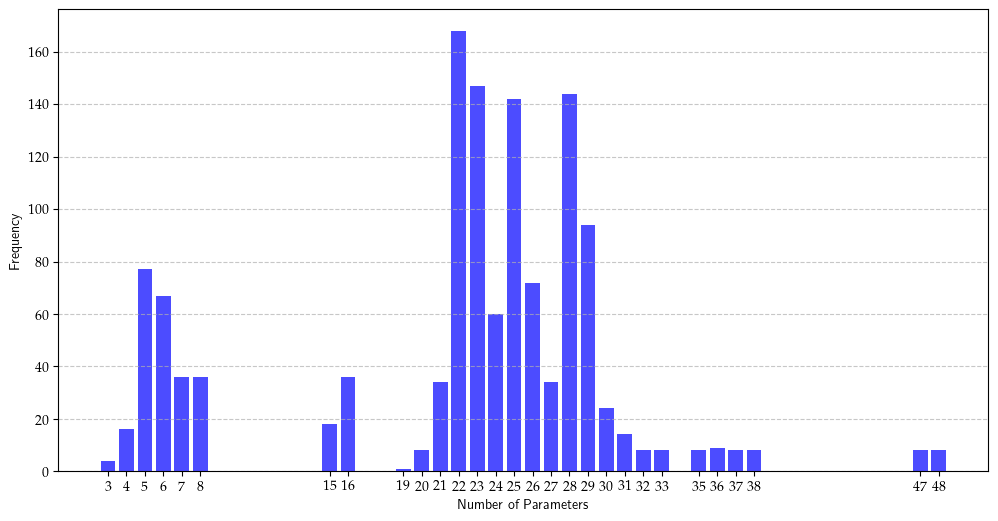

In [472]:
plt.figure(figsize=(12, 6))
plt.bar(nparams, freq, color='blue', alpha=0.7)
plt.xlabel('Number of Parameters')
plt.ylabel('Frequency')
plt.xticks(nparams)  # Ensure all parameter values are shown on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
# plt.savefig(f"nparams-planck.pdf", transparent=False, bbox_inches="tight")
plt.show()

## Triangle Plot

In [473]:
ids_max = [test_sorted[test_sorted['nparams'] == nparam]['log-evi'].idxmax() for nparam in nparams]

In [474]:
test_max_per_param = test_sorted.iloc[ids_max].reset_index(drop=True)

In [475]:
test_max_per_param[['experiment', 'nparams', 'log-vol', 'log-fit', 'log-evi']]

,experiment,nparams,log-vol,log-fit,log-evi
0,base_BAO_Cooke17,3,-15.799986,37.170833,21.370847
1,base_mnu_BAO_Cooke17,4,-15.441364,39.696802,24.255437
2,base_nnu_mnu_BAO_Cooke17Adel_Aver15,5,-16.731734,165.785209,149.053475
3,base_mnu_lensing_DESpriors,6,-12.331813,18.418341,6.086528
4,base_nnu_mnu_lensing_lenspriors_BAO_Cooke17_Av...,7,-25.840098,39.662203,13.822105
5,base_nnu_plikHM_EE_lowE_BAO,8,-41.532477,-541.739462,-583.271939
6,base_DESlens_DESpriors,15,-41.187167,-65.504684,-106.691850
7,base_mnu_DESlens_lenspriors_BAO,16,-55.837637,-36.666733,-92.504370
8,base_CleanedCamSpecHM_TT_lowl_lowE,19,-60.282380,-3539.801261,-3600.083641
9,base_mnu_CleanedCamSpecHM_TT_lowl_lowE,20,-61.924327,-3526.762836,-3588.687163


In [476]:
# topZ_samples, topZ_info = get_mcmc_samples(test_max.iloc[5]['path'])
# topZ_samples, topZ_info = get_mcmc_samples(test_sorted.iloc[181]['path'])
topZ_samples, topZ_info = get_mcmc_samples(test_max_per_param.iloc[16]['path'])

In [477]:
topZ_samples.head()

,logp,omegabh2,omegach2,theta,tau,logA,ns,acib217,xi,asz143,...,kgal217,galfTE100,galfTE100143,galfTE100217,galfTE143,galfTE143217,galfTE217,cal0,cal2,calPlanck
0,-1181.982,0.022345,0.119311,1.040694,0.134161,3.194077,0.968688,45.63290,0.805417,3.563559,...,91.33910,0.158946,0.146251,0.453086,0.249530,0.592682,1.949295,0.999296,0.999125,0.997328
1,-1178.442,0.022331,0.118670,1.040497,0.136399,3.197504,0.970598,48.36416,0.767341,6.381944,...,89.00918,0.135874,0.139574,0.439009,0.215684,0.656602,1.983278,0.999744,0.999015,0.997499
2,-1186.872,0.022325,0.118540,1.040526,0.134920,3.194348,0.970470,36.45766,0.466837,2.282902,...,99.25705,0.128761,0.120135,0.571399,0.145306,0.503230,1.509082,0.999560,0.998869,0.998537
3,-1193.791,0.022342,0.117874,1.040692,0.139894,3.203547,0.971960,35.42288,0.075040,4.520108,...,98.99506,0.105685,0.131977,0.235048,0.178488,0.689832,1.940540,0.999434,0.998968,0.998034
4,-1192.338,0.022190,0.118505,1.040435,0.101829,3.133730,0.969823,39.25138,0.157312,4.641995,...,91.00331,0.068861,0.126439,0.406782,0.114679,0.618301,2.319175,1.000006,0.998631,1.001439


In [325]:
# generate_triangle_plot(topZ_samples.values[:,1:], get_latex_labels(topZ_info))

## Planck Only - plik

In [478]:
contains_plik = ['plik' in e for e in test_sorted['experiment'].values]

In [479]:
test_plik = test_sorted[contains_plik].reset_index(drop=True)

In [480]:
test_plik.shape

(675, 7)

In [481]:
test_plik.head(10)

,base,experiment,path,nparams,log-vol,log-fit,log-evi
0,base,base_plikHM_TT,base/plikHM_TT/base_plikHM_TT,21,-48.796277,-353.547948,-402.344225
1,base_Alens,base_Alens_plikHM_TT,base_Alens/plikHM_TT/base_Alens_plikHM_TT,22,-50.976199,-351.626879,-402.603079
2,base_Alens,base_Alens_plikHM_TT_post_zre6p5,base_Alens/plikHM_TT/base_Alens_plikHM_TT_post...,22,-51.159507,-351.447930,-402.607438
3,base_mnu,base_mnu_plikHM_TT_lowl_lensing_post_zre6p5,base_mnu/plikHM_TT_lowl_lensing/base_mnu_plikH...,22,-50.960921,-357.980871,-408.941792
4,base_mnu,base_mnu_plikHM_TT_lowl_lensing,base_mnu/plikHM_TT_lowl_lensing/base_mnu_plikH...,22,-50.927326,-358.154628,-409.081954
5,base_Alens,base_Alens_plikHM_TT_lowl_post_zre6p5,base_Alens/plikHM_TT_lowl/base_Alens_plikHM_TT...,22,-51.661667,-357.494628,-409.156294
6,base_Alens,base_Alens_plikHM_TT_lowl,base_Alens/plikHM_TT_lowl/base_Alens_plikHM_TT...,22,-51.388951,-359.090456,-410.479407
7,base,base_plikHM_TT_lowl_reion,base/plikHM_TT_lowl_reion/base_plikHM_TT_lowl_...,21,-50.172711,-363.460042,-413.632753
8,base,base_plikHM_TT_lowl_lensing_post_zre6p5,base/plikHM_TT_lowl_lensing/base_plikHM_TT_low...,21,-49.571727,-364.083763,-413.655490
9,base_mnu,base_mnu_plikHM_TT_lowl_lensing_post_BAO_zre6p5,base_mnu/plikHM_TT_lowl_lensing/base_mnu_plikH...,22,-51.085374,-362.670187,-413.755561


In [482]:
log_evi_sm = softmax(test_plik['log-evi'])
log_evi_sm[log_evi_sm < 1E-3] = 0
test_plik['score'] = log_evi_sm

In [483]:
test_plik.head()

,base,experiment,path,nparams,log-vol,log-fit,log-evi,score
0,base,base_plikHM_TT,base/plikHM_TT/base_plikHM_TT,21,-48.796277,-353.547948,-402.344225,0.392999
1,base_Alens,base_Alens_plikHM_TT,base_Alens/plikHM_TT/base_Alens_plikHM_TT,22,-50.976199,-351.626879,-402.603079,0.303370
2,base_Alens,base_Alens_plikHM_TT_post_zre6p5,base_Alens/plikHM_TT/base_Alens_plikHM_TT_post...,22,-51.159507,-351.447930,-402.607438,0.302051
3,base_mnu,base_mnu_plikHM_TT_lowl_lensing_post_zre6p5,base_mnu/plikHM_TT_lowl_lensing/base_mnu_plikH...,22,-50.960921,-357.980871,-408.941792,0.000000
4,base_mnu,base_mnu_plikHM_TT_lowl_lensing,base_mnu/plikHM_TT_lowl_lensing/base_mnu_plikH...,22,-50.927326,-358.154628,-409.081954,0.000000


In [577]:
samples_0, samples_0_derived, info_0 = get_mcmc_samples(test_plik.iloc[0]['path'])
samples_1, samples_1_derived, info_1 = get_mcmc_samples(test_plik.iloc[1]['path'])
samples_2, samples_2_derived, info_2 = get_mcmc_samples(test_plik.iloc[2]['path'])

In [546]:
log_vol_0, log_fit_0, log_evi_nf_0 = evidence_estimate(samples_0.values[:,1:], samples_0.values[:,0], 
                                                       trainflow=True, nsamplesflow=15000, nsteps=1000)

log_vol_1, log_fit_1, log_evi_nf_1 = evidence_estimate(samples_1.values[:,1:], samples_1.values[:,0], 
                                                       trainflow=True, nsamplesflow=15000, nsteps=1000)

log_vol_2, log_fit_2, log_evi_nf_2 = evidence_estimate(samples_2.values[:,1:], samples_2.values[:,0], 
                                                       trainflow=True, nsamplesflow=15000, nsteps=1000)

We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [06:27<00:00,  2.58it/s, Loss=29.196]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [06:34<00:00,  2.54it/s, Loss=30.586]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [06:35<00:00,  2.53it/s, Loss=30.503]


In [547]:
softmax([log_evi_nf_0, log_evi_nf_1, log_evi_nf_2])

array([0.47529877, 0.26203936, 0.26266187])

### Harmonic

In [539]:
def compute_hm_evidence(samples, log_probabilities, sample_count=15000, scaled_layers=2, unscaled_layers=4, temp=1.0, epochs=20):
    """
    Trains a RealNVP model using Monte Carlo chains, applies a transformation to samples, 
    and computes the log evidence for the model using the provided samples and log probabilities.

    Parameters:
    -----------
    samples : np.ndarray
        Array of sample data to be used for training and evidence computation.
    log_probabilities : np.ndarray
        Logarithmic probabilities corresponding to the sample data.
    sample_count : int, optional
        The number of samples to use for training (default: 15000).
    scaled_layers : int, optional
        Number of scaled layers in the RealNVP model (default: 2).
    unscaled_layers : int, optional
        Number of unscaled layers in the RealNVP model (default: 4).
    temp : float, optional
        Temperature parameter for the RealNVP model (default: 1.0).
    epochs : int, optional
        Number of epochs for training the model (default: 20).

    Returns:
    --------
    log_determinant_chol : float
        Log-determinant of the Cholesky decomposition from the transformation.
    log_sum_exp : float
        Log-sum-exp of the negative inverse of the model evidence.
    log_evidence : float
        Estimated log evidence (marginal likelihood) for the model.
    """
    
    nsamples, ndim = samples.shape
    selected_indices = random.sample(range(nsamples), sample_count)
    
    # Apply transformation to the selected samples
    samples_chosen = samples[selected_indices]
    transform = ThetaTransform(samples_chosen)
    samples_prime = transform.forward(samples_chosen)
    
    # Initialize and add chains
    chains = hm.Chains(ndim)
    chains.add_chains_2d(samples_prime, log_probabilities[selected_indices], 1)
    
    # Train RealNVP model
    model = hm.model.RealNVPModel(ndim, standardize=True, temperature=temp)
    model.fit(chains.samples, epochs=epochs, verbose=True)
    
    # Compute evidence
    evidence = hm.Evidence(chains.nchains, model)
    evidence.add_chains(chains)

    log_sum_exp = -evidence.ln_evidence_inv
    log_evidence = transform.logdetchol + log_sum_exp
    
    return transform.logdetchol, log_sum_exp, log_evidence

In [548]:
log_vol_hm_0, log_fit_hm_0, log_z_hm_0 = compute_hm_evidence(samples_0.values[:,1:], samples_0.values[:,0], epochs=1000)
log_vol_hm_1, log_fit_hm_1, log_z_hm_1 = compute_hm_evidence(samples_1.values[:,1:], samples_1.values[:,0], epochs=1000)
log_vol_hm_2, log_fit_hm_2, log_z_hm_2 = compute_hm_evidence(samples_2.values[:,1:], samples_2.values[:,0], epochs=1000)

Training NF: 100%|███████████████████████████████████████████████████| 1000/1000 [04:25<00:00,  3.77it/s]


In [549]:
softmax([log_z_hm_0, log_z_hm_1, log_z_hm_2])

array([0.49968646, 0.28157328, 0.21874026])

In [ ]:
# array([0.393, 0.303, 0.302]) # gauss
# array([0.504, 0.266, 0.230]) # emuflow
# array([0.500, 0.253, 0.246]) # harmonic

## plikHM_TTTEEE_lowl_lowE

In [656]:
def compute_log_evidence_emuflow(dataframe, num_samples, num_steps=10):
    """
    Computes the log evidence and log best fit using EmuFlow for each experiment in the dataframe.
    
    This function estimates the log evidence and log best fit for a set of MCMC samples using
    a flow-based model. It adds the results to a new dataframe, which includes both Gaussian 
    evidence-based scores and flow-based scores.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        A dataframe containing experiment metadata. Each row must contain a 'path' column 
        pointing to the location of MCMC samples.
    num_samples : int
        Number of samples to use in the flow-based evidence estimation process.
    num_steps : int, optional, default=10
        Number of steps for training the flow-based model.

    Returns:
    --------
    pandas.DataFrame
        A copy of the input dataframe with added columns:
        - 'scores-gauss': Softmax scores based on Gaussian log-evidence.
        - 'log-fit-nf': Log best fit values from the flow-based evidence estimation.
        - 'log-evi-nf': Log evidence values from the flow-based evidence estimation.
        - 'scores-nf': Softmax scores based on the flow-based log-evidence.
    """
    log_evidence_flow = []
    log_best_fit_flow = []
    num_experiments = dataframe.shape[0]
    
    for exp_idx in range(num_experiments):
        samples, derived_samples, info = get_mcmc_samples(dataframe.iloc[exp_idx]['path'])
        
        log_volume, log_fit, log_evidence = evidence_estimate(
            samples.values[:, 1:], 
            samples.values[:, 0], 
            trainflow=True, 
            nsamplesflow=num_samples, 
            nsteps=num_steps
        )
        
        log_evidence_flow.append(log_evidence)
        log_best_fit_flow.append(log_fit)

    result_df = dataframe.copy()
    result_df['scores-gauss'] = softmax(dataframe['log-evi'].values)
    result_df['log-fit-nf'] = log_best_fit_flow
    result_df['log-evi-nf'] = log_evidence_flow
    result_df['scores-nf'] = softmax(log_evidence_flow)

    return result_df


def compute_weighted_posterior(dataframe, num_samples=15000, use_flow=False):
    """
    Computes the weighted posterior samples from multiple experiments, using Gaussian or flow-based weights.

    This function combines posterior samples from multiple experiments, where the contribution of each
    experiment is weighted by either Gaussian-based or flow-based evidence scores.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        A dataframe containing experiment metadata and scores. Must contain a 'path' column pointing 
        to the MCMC samples for each experiment and either 'scores-gauss' or 'scores-nf' columns.
    num_samples : int, optional, default=15000
        Number of samples to draw from the posterior of each experiment.
    use_flow : bool, optional, default=False
        If True, use the flow-based scores ('scores-nf') for weighting the posterior. 
        Otherwise, use Gaussian-based scores ('scores-gauss').

    Returns:
    --------
    tuple:
        - dict: A dictionary where keys are experiment names and values are the selected derived samples 
                ('omegam*', 'S8*', 'H0*') for each experiment.
        - numpy.ndarray: The weighted sum of posterior samples across experiments.
    """
    derived_sample_dict = {}
    weighted_samples = []
    
    # Choose either Gaussian or flow-based scores
    weights = dataframe['scores-gauss'].values if not use_flow else dataframe['scores-nf'].values
    
    for exp_idx in range(len(weights)):
        samples, derived_samples, info = get_mcmc_samples(dataframe.iloc[exp_idx]['path'])
        
        # Randomly sample from the derived samples
        selected_indices = random.sample(range(0, samples.shape[0]), num_samples)
        selected_derived_samples = derived_samples[['omegam*', 'S8*', "H0*"]].iloc[selected_indices]
        
        experiment_name = dataframe['experiment'].values[exp_idx]
        derived_sample_dict[experiment_name] = selected_derived_samples
        
        # Weight the selected samples by the corresponding score
        weighted_samples.append(weights[exp_idx] * selected_derived_samples.values)
    
    # Sum the weighted samples to obtain the combined posterior
    combined_posterior = sum(weighted_samples)
    
    return derived_sample_dict, combined_posterior

In [558]:
contains_plik_low = [True if s.endswith("plikHM_TTTEEE_lowl_lowE") else False for s in test_sorted['experiment'].values]

In [568]:
test_plik_ttteee = test_sorted[contains_plik_low].reset_index(drop=True)

In [655]:
test_plik_ttteee[['base', 'experiment', 'nparams', 'log-vol', 'log-fit', 'log-evi']]

,base,experiment,nparams,log-vol,log-fit,log-evi
0,base_nnu_meffsterile,base_nnu_meffsterile_plikHM_TTTEEE_lowl_lowE,29,-71.277153,-1328.864406,-1400.141559
1,base_nnu_mnu,base_nnu_mnu_plikHM_TTTEEE_lowl_lowE,29,-71.846566,-1328.982695,-1400.829261
2,base_nnu_yhe,base_nnu_yhe_plikHM_TTTEEE_lowl_lowE,29,-73.285065,-1336.491919,-1409.776984
3,base_mnu,base_mnu_plikHM_TTTEEE_lowl_lowE,28,-70.450815,-1339.516284,-1409.967099
4,base_nnu,base_nnu_plikHM_TTTEEE_lowl_lowE,28,-69.650361,-1340.969069,-1410.619429
5,base_Alens,base_Alens_plikHM_TTTEEE_lowl_lowE,28,-70.857821,-1345.549572,-1416.407393
6,base_w,base_w_plikHM_TTTEEE_lowl_lowE,28,-69.317395,-1347.900033,-1417.217429
7,base_omegak,base_omegak_plikHM_TTTEEE_lowl_lowE,28,-72.295434,-1344.994070,-1417.289504
8,base,base_plikHM_TTTEEE_lowl_lowE,27,-67.956912,-1350.026871,-1417.983784
9,base_r,base_r_plikHM_TTTEEE_lowl_lowE,28,-71.365550,-1347.144474,-1418.510024


In [663]:
df_flow = compute_log_evidence_emuflow(test_plik_ttteee, num_samples=15000, num_steps=1000)

We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [13:01<00:00,  1.28it/s, Loss=39.798]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [11:03<00:00,  1.51it/s, Loss=40.222]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [10:47<00:00,  1.54it/s, Loss=40.305]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [09:58<00:00,  1.67it/s, Loss=38.866]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [09:58<00:00,  1.67it/s, Loss=39.115]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [10:54<00:00,  1.53it/s, Loss=38.998]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [10:29<00:00,  1.59it/s, Loss=39.037]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [10:22<00:00,  1.61it/s, Loss=39.037]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [10:50<00:00,  1.54it/s, Loss=37.660]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [09:46<00:00,  1.70it/s, Loss=38.895]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [11:21<00:00,  1.47it/s, Loss=40.313]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [10:54<00:00,  1.53it/s, Loss=40.395]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [10:21<00:00,  1.61it/s, Loss=39.049]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [09:28<00:00,  1.76it/s, Loss=39.091]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [10:16<00:00,  1.62it/s, Loss=40.471]


We are using 15000 samples in the Normalising Flow.


100%|███████████████████████████████████████████████████| 1000/1000 [09:39<00:00,  1.73it/s, Loss=38.965]


In [668]:
df_flow.loc[:, df_flow.columns != 'path']

,base,experiment,nparams,log-vol,log-fit,log-evi,scores-gauss,log-fit-nf,log-evi-nf,scores-nf
0,base_nnu_meffsterile,base_nnu_meffsterile_plikHM_TTTEEE_lowl_lowE,29,-71.277153,-1328.864406,-1400.141559,6.653902e-01,-1356.004502,-1427.272823,0.009344
1,base_nnu_mnu,base_nnu_mnu_plikHM_TTTEEE_lowl_lowE,29,-71.846566,-1328.982695,-1400.829261,3.345115e-01,-1355.722981,-1427.608851,0.006677
2,base_nnu_yhe,base_nnu_yhe_plikHM_TTTEEE_lowl_lowE,29,-73.285065,-1336.491919,-1409.776984,4.349751e-05,-1355.835142,-1429.170862,0.001400
3,base_mnu,base_mnu_plikHM_TTTEEE_lowl_lowE,28,-70.450815,-1339.516284,-1409.967099,3.596652e-05,-1356.163593,-1426.608107,0.018164
4,base_nnu,base_nnu_plikHM_TTTEEE_lowl_lowE,28,-69.650361,-1340.969069,-1410.619429,1.873248e-05,-1354.780623,-1424.456909,0.156125
5,base_Alens,base_Alens_plikHM_TTTEEE_lowl_lowE,28,-70.857821,-1345.549572,-1416.407393,5.740035e-08,-1352.804211,-1423.659160,0.346682
6,base_w,base_w_plikHM_TTTEEE_lowl_lowE,28,-69.317395,-1347.900033,-1417.217429,2.553410e-08,-1354.840633,-1424.165599,0.208923
7,base_omegak,base_omegak_plikHM_TTTEEE_lowl_lowE,28,-72.295434,-1344.994070,-1417.289504,2.375847e-08,-1351.848203,-1424.166636,0.208707
8,base,base_plikHM_TTTEEE_lowl_lowE,27,-67.956912,-1350.026871,-1417.983784,1.186579e-08,-1357.896604,-1425.890682,0.037221
9,base_r,base_r_plikHM_TTTEEE_lowl_lowE,28,-71.365550,-1347.144474,-1418.510024,7.010573e-09,-1357.181040,-1428.575526,0.002540


In [665]:
derived_samples, weighted_samples_gauss = compute_weighted_posterior(df_flow, use_flow=False)
_, weighted_samples_nf = compute_weighted_posterior(df_flow, use_flow=True)

In [669]:
names = ["x%s"%i for i in range(3)]
labels =  [r"$\Omega_{m}$", r"$S_{8}$", r"$H_{0}$"]
samples_weighted_gauss = MCSamples(samples=weighted_samples_gauss,names = names, labels = labels, label = 'weighted (Gaussian)')
samples_weighted_nf = MCSamples(samples=weighted_samples_nf,names = names, labels = labels, label = 'weighted (Flow)')

samples_0 = MCSamples(samples=derived_samples['base_Alens_plikHM_TTTEEE_lowl_lowE'].values, names = names, labels = labels, label='base_Alens')
samples_1 = MCSamples(samples=derived_samples['base_w_plikHM_TTTEEE_lowl_lowE'].values, names = names, labels = labels, label='base_w')
samples_2 = MCSamples(samples=derived_samples['base_omegak_plikHM_TTTEEE_lowl_lowE'].values, names = names, labels = labels, label='base_omegak')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


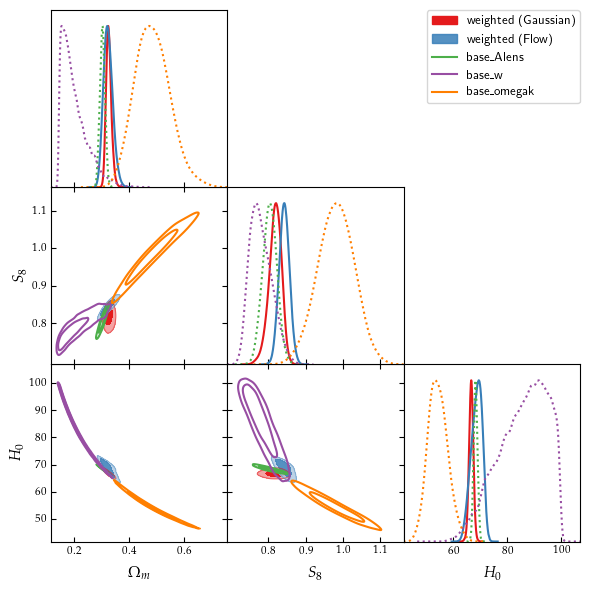

In [670]:
colors = plt.get_cmap('Set1').colors[:5]
g = plots.get_subplot_plotter()
g.triangle_plot([samples_weighted_gauss, samples_weighted_nf, samples_0, samples_1, samples_2], 
                filled=[True, True, False, False, False], 
                legend_loc='upper right', 
                line_args=[{'ls':'-', 'color':colors[0]},
                           {'ls':'-', 'color':colors[1]},
                           {'ls':':', 'color':colors[2]},
                           {'ls':':', 'color':colors[3]},
                           {'ls':':', 'color':colors[4]}], 
                contour_colors=colors,
                contour_lws=[1.5, 1.5, 1.5, 1.5, 1.5])
plt.show()

## Idea - Use SDDR for low dimensional posterior.

In [ ]:
def compute_log_evidences(log_bayes_factors):

    max_log_bf = np.max(log_bayes_factors)
    
    # Calculate the exponentials of the log Bayes factors to get the Bayes factors
    bayes_factors = np.exp(log_bayes_factors - max_log_bf)

    # Calculate the normalization factor
    normalization_factor = np.sum(bayes_factors) + 1  # +1 for Z_2

    # Calculate the log evidences
    log_evidences = np.log(bayes_factors / normalization_factor)

    # Append log evidence for the reference model (Z_2)
    log_evidences = np.append(log_evidences, np.log(1 / normalization_factor))

    return log_evidences

In [ ]:
# Example usage:
log_exact_evidences = np.array([-1400.141559, -1400.829261, -1417.983784])
log_bayes_factors = np.array([17.842225, 17.154523])  # Add more log Bayes factors if needed
log_evidences = compute_log_evidences(log_bayes_factors)

# Display the results
for i, log_evidence in enumerate(log_evidences):
    print(f"Log Evidence for Model {i+1}: {log_evidence:.6f}")

In [ ]:
softmax(log_exact_evidences)
softmax(log_evidences)